In [1]:
import os
# transformer多点预测架构多点预测测试版
from DataLoader import time_series_decoder_paper
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
from torch.utils.data import DataLoader
from ProcessData import process_data3

In [2]:
class TransformerTimeSeries(torch.nn.Module):
    def __init__(self, train_length, forcast_window):
        super(TransformerTimeSeries, self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(2,256, 9)
        self.positional_embedding = torch.nn.Embedding(100, 256)
        self.decoder_layer = torch.nn.TransformerEncoderLayer(d_model=256, nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decoder_layer, num_layers=3)
        self.fc1 = torch.nn.Linear(256,1)
        self.train_length = train_length
        self.forcast_window = forcast_window

    def _generate_square_subsequent_mask(self):
        mask = torch.zeros(self.train_length + self.forcast_window, self.train_length + self.forcast_window)
        for i in range(0, self.train_length):
            mask[i, self.train_length:] = 1
        for i in range(self.train_length, self.train_length + self.forcast_window):
            mask[i, i + 1:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))  # .masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x, y):
        z = torch.cat((y.unsqueeze(1), x.unsqueeze(1)), dim=1) #[batch, feature, time_step]
        z_embedding = self.input_embedding(z).permute(2,0,1) #[time_step, batch, feature]

        # before [batch, time, feature]
        # after [time, batch, feature]
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)

        input_embedding = z_embedding+positional_embeddings
        mask = self._generate_square_subsequent_mask().cuda()
        transformer_embedding = self.transformer_decoder(input_embedding, mask)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        return output

In [3]:
train_length = 24
forcast_window = 24
csv_name = "Palo Alto"

In [4]:
# train_data, test_data = process_data3(csv_name, train_length, forcast_window)

In [5]:
train_dataset = time_series_decoder_paper(train_length, 4500)
validation_dataset = time_series_decoder_paper(train_length,500)
test_dataset = time_series_decoder_paper(train_length,1000)

x: 4500*48 fx: 4500*48
x: 500*48 fx: 500*48
x: 1000*48 fx: 1000*48


In [6]:
criterion = torch.nn.MSELoss()

In [7]:
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True) # [batch_size, feature_size]
validation_dl = DataLoader(validation_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

In [8]:
model = TransformerTimeSeries(train_length, forcast_window).cuda()

In [9]:
lr = .0005 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100

In [10]:
def Dp(y_pred,y_true,q): # softmax更新
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

In [11]:
def Rp_num_den(y_preds,y_trues,q): # RPloss
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [12]:
def train_epoch(model,train_dl,train_length=96, forcast_window=24):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,y,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x.cuda(),y.cuda())
        # print('train_output.shape:', output.shape)
        # print('test_output.suqeeze.shape:', output.squeeze(-1).shape)
        loss = criterion(output.squeeze(-1)[:,(train_length-1):(train_length+forcast_window-1)],y.cuda()[:,train_length:]) # not missing data
        # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
        loss.backward()
        optimizer.step()

        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

In [13]:
def eval_epoch(model,validation_dl,train_length=96, forcast_window=24):
    model.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda())
            loss = criterion(output.squeeze()[:,(train_length-1):(train_length+forcast_window-1)],y.cuda()[:,train_length:]) # not missing data
            # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data

            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]

    return eval_loss/n

In [14]:
def test_epoch(model,test_dl,train_length=96, forcast_window=24):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda())
            # print('test_output.shape:', output.shape)
            # print(output.shape) #[batch, seq_len, feature] [128, 48, 1]
            for p,o in zip(output.squeeze(-1)[:,(train_length-1):(train_length+forcast_window-1)].cpu().numpy().tolist(),y.cuda()[:,train_length:].cpu().numpy().tolist()): # not missing data
            #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data


                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den

    return Rp

In [15]:
train_epoch_loss = []
eval_epoch_loss = []
Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []

    l_t = train_epoch(model,train_dl,train_length,forcast_window)
    train_loss.append(l_t)

    l_e = eval_epoch(model,validation_dl,train_length,forcast_window)
    eval_loss.append(l_e)

    Rp = test_epoch(model,test_dl,train_length,forcast_window)

    if Rp_best > Rp:
        Rp_best = Rp

    train_epoch_loss.append(np.mean(train_loss))
    eval_epoch_loss.append(np.mean(eval_loss))

    print("Epoch {}: Train loss: {} \t Validation loss: {} \t R_p={}".format(e,
                                                             np.mean(train_loss),
                                                             np.mean(eval_loss),Rp))

F:\ENV_py\PYTORCH\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0: Train loss: 3828.316657769097 	 Validation loss: 2646.183978515625 	 R_p=0.6035633090654173
Epoch 1: Train loss: 1870.1485859375 	 Validation loss: 1141.95166796875 	 R_p=0.3660145333205866
Epoch 2: Train loss: 722.7790666503906 	 Validation loss: 388.21109350585937 	 R_p=0.17727163604122806
Epoch 3: Train loss: 257.5202127549913 	 Validation loss: 140.10969946289063 	 R_p=0.09085615322057569
Epoch 4: Train loss: 100.26209301079643 	 Validation loss: 56.86879904174805 	 R_p=0.05394464922409515
Epoch 5: Train loss: 44.40065755377876 	 Validation loss: 26.812262802124025 	 R_p=0.03844052234479511
Epoch 6: Train loss: 22.242153377956814 	 Validation loss: 13.73846371459961 	 R_p=0.027024475897496774
Epoch 7: Train loss: 12.418966857062445 	 Validation loss: 8.227742897033691 	 R_p=0.022623984754175708
Epoch 8: Train loss: 7.877588237762451 	 Validation loss: 5.566736461639405 	 R_p=0.020237927896718345
Epoch 9: Train loss: 5.3708930443657765 	 Validation loss: 4.247959980010986 	

In [16]:
print("Rp best={}".format(Rp_best))

Rp best=0.012161488031783548


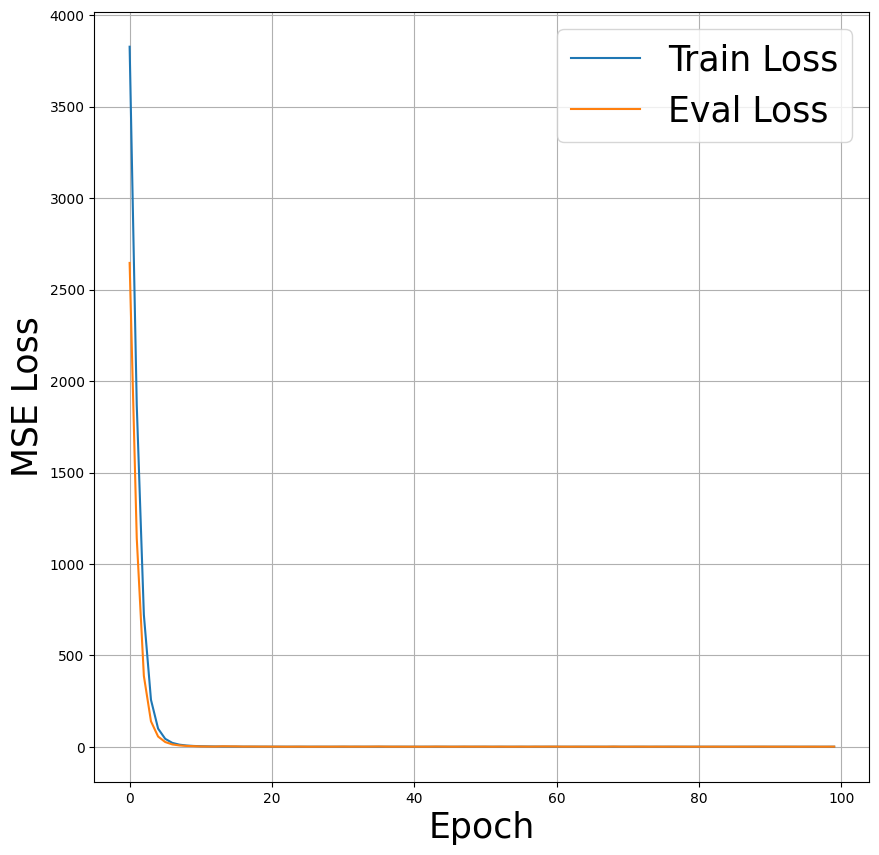

In [17]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.plot(eval_epoch_loss)
plt.legend(['Train Loss','Eval Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.grid()
plt.show()

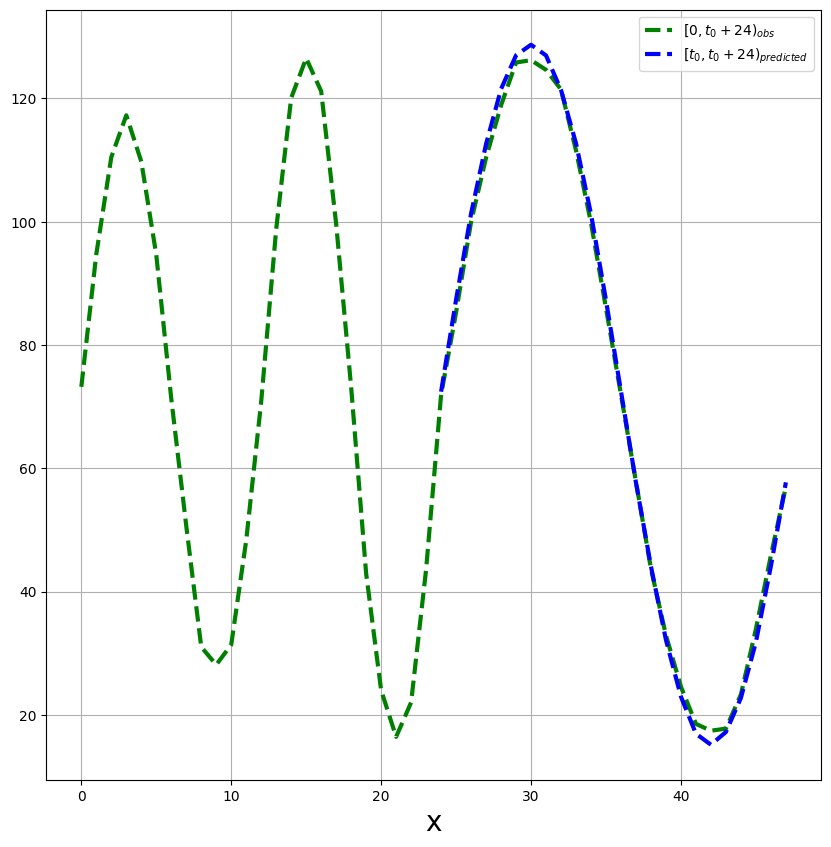

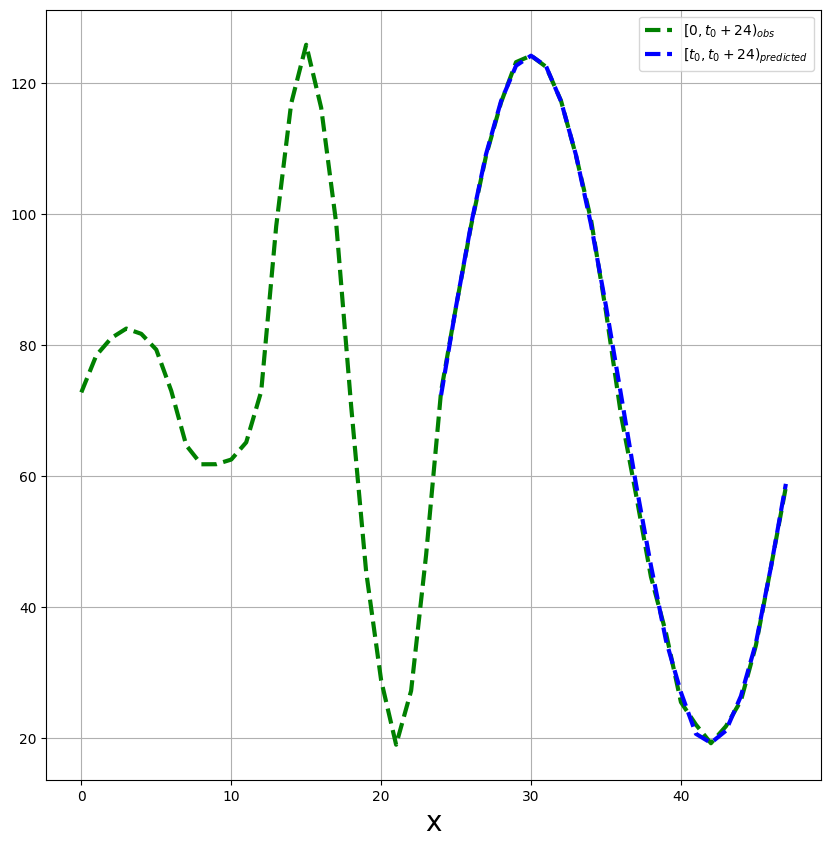

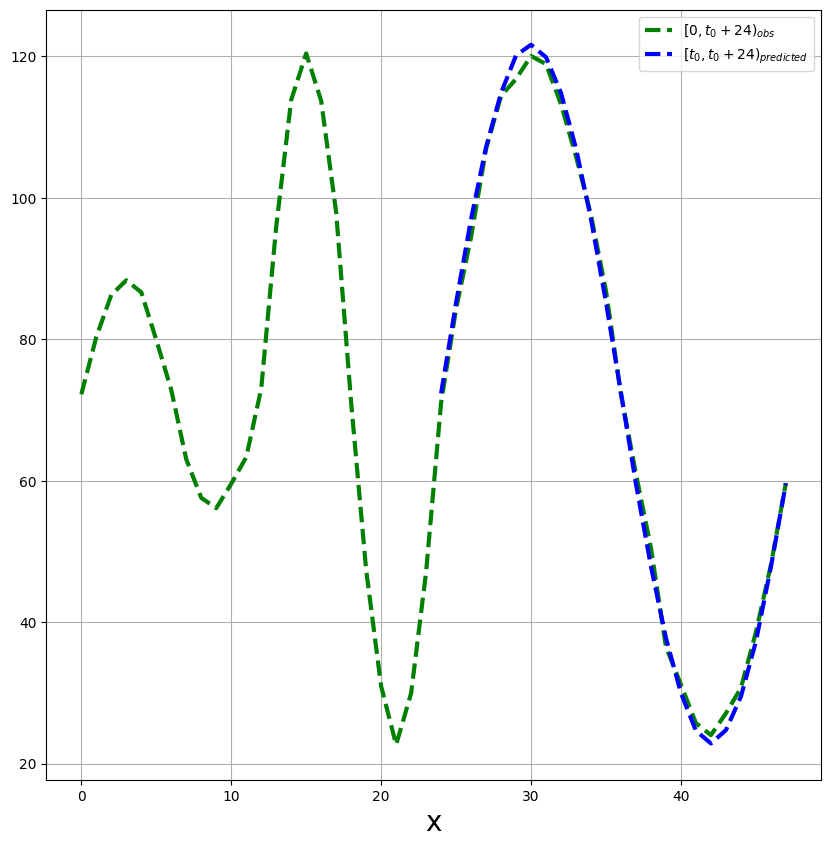

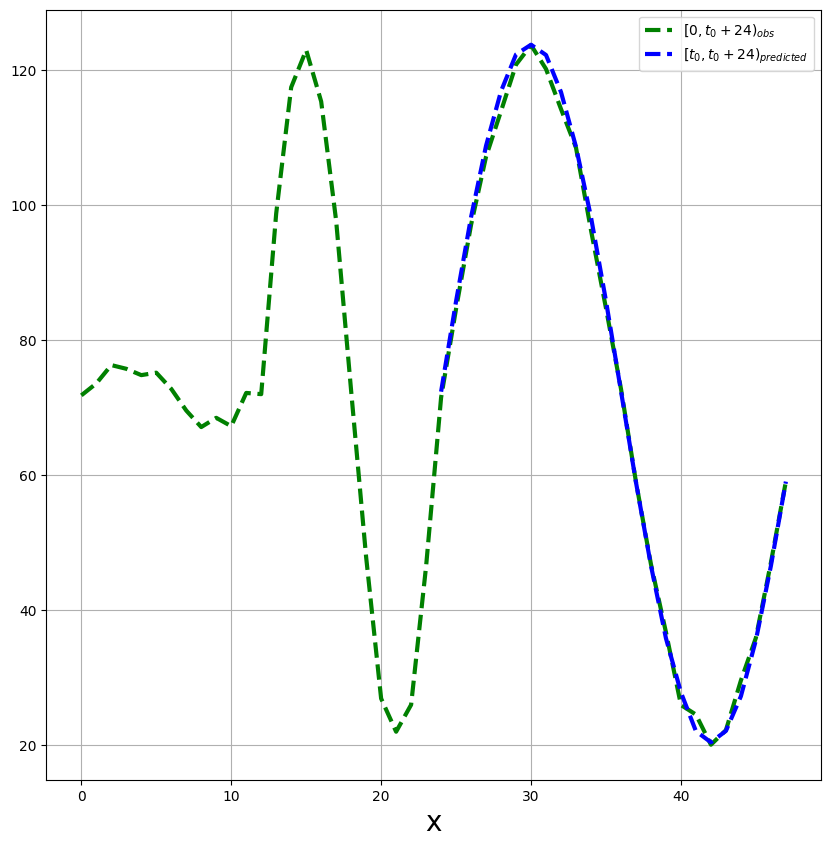

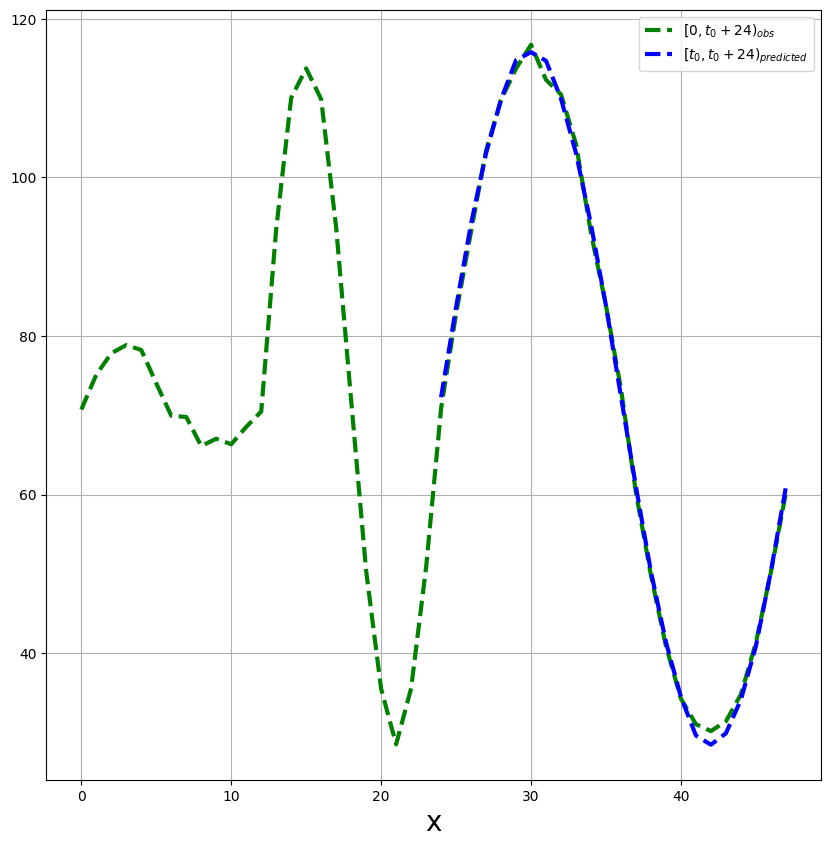

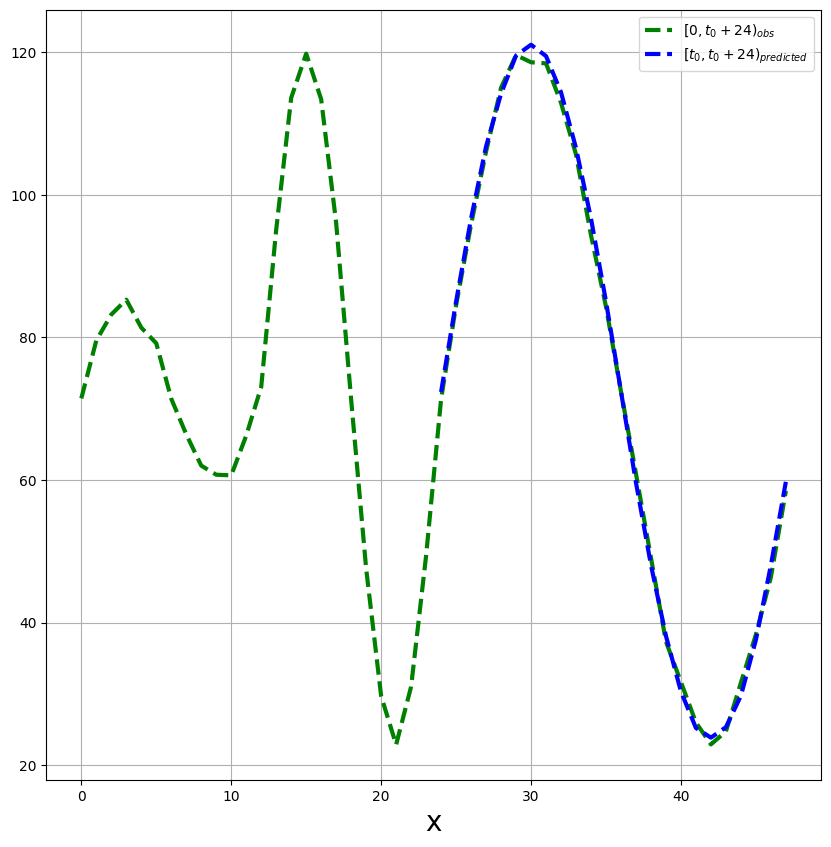

In [18]:
n_plots = 5
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda())

            if step > n_plots:
                break

            with torch.no_grad():
                plt.figure(figsize=(10,10))
                plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)
                plt.plot(x[0,train_length:].cpu().detach().squeeze().numpy(),output[0,(train_length-1):(train_length+forcast_window-1)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # not missing data
                # plt.plot(x[0,(t0-10):].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
                plt.xlabel("x",fontsize=20)
                plt.legend(["$[0,t_0+24)_{obs}$","$[t_0,t_0+24)_{predicted}$"])
                plt.grid()
                plt.show()

In [19]:
def get_attn(model,x,y,attention_masks):
    model.eval()
    with torch.no_grad():
        x=x.cuda(); y=y.cuda(); attention_masks = attention_masks.cuda()
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        z_embedding = model.input_embedding(z).permute(2,0,1) # (sequence len,Batch size,embedding_size)
        positional_embeddings = model.positional_embedding(x.type(torch.long)).permute(1,0,2)
        input_embedding = z_embedding+positional_embeddings

        attn_layer_i = []
        for layer in model.transformer_decoder.layers:
            print(layer.self_attn(input_embedding,input_embedding,input_embedding,attn_mask=attention_masks)[-1].shape)
            attn_layer_i.append(layer.self_attn(input_embedding,input_embedding,input_embedding,attn_mask=attention_masks)[-1].squeeze().cpu().detach().numpy())
            input_embedding = layer.forward(input_embedding,attention_masks)

        return attn_layer_i

In [20]:
idx_example = 0

In [21]:
attn_layers = get_attn(model,test_dataset[idx_example][0].unsqueeze(0),test_dataset[idx_example][1].unsqueeze(0),test_dataset[idx_example][2])

torch.Size([1, 48, 48])
torch.Size([1, 48, 48])
torch.Size([1, 48, 48])


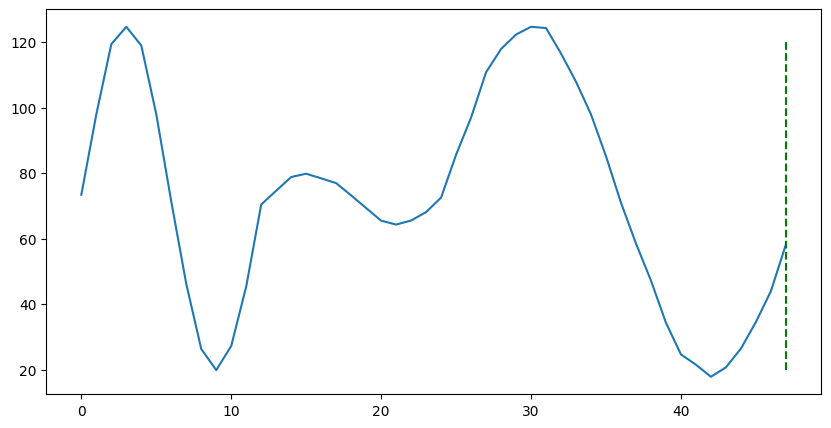

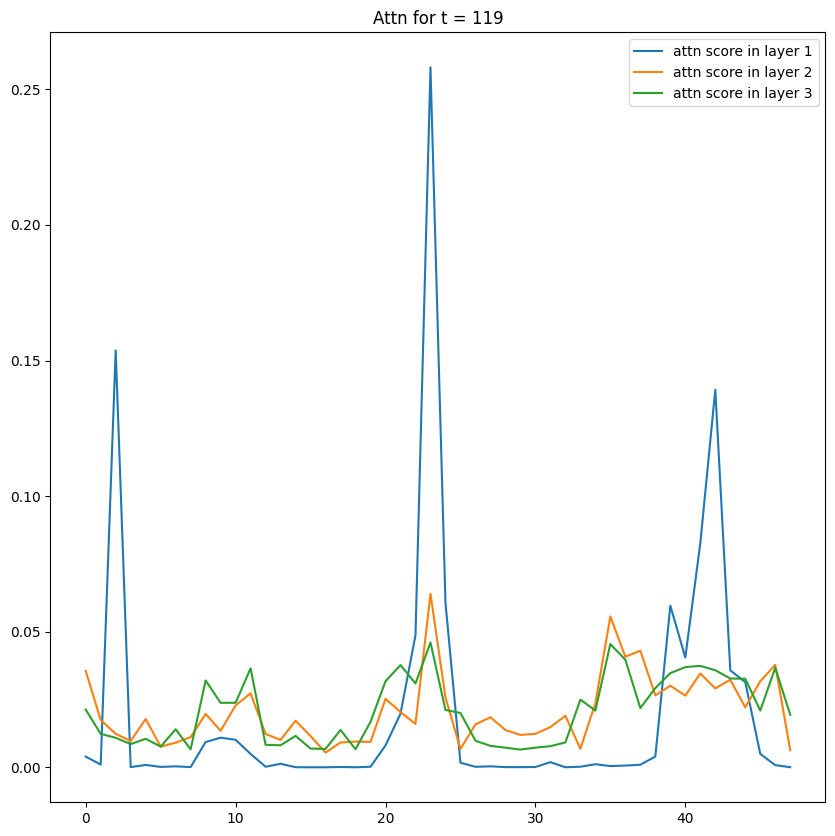

In [22]:
plt.figure(figsize=(10,5))
plt.plot(test_dataset[idx_example][0].numpy(),train_dataset[10][1].numpy())
plt.plot([train_length+forcast_window-1,train_length+forcast_window-1],[20,120],'g--') # not missing data
# plt.plot([t0+24-1,t0+24-1],[20,120],'g--') # missing data
plt.figure(figsize=(10,10))
plt.plot(attn_layers[0][train_length+forcast_window-1]) # not missing data
plt.plot(attn_layers[1][train_length+forcast_window-1]) # not missing data
plt.plot(attn_layers[2][train_length+forcast_window-1]) # not missing data

#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[0][119-10]) # missing data
#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[1][119-10]) # missing data
#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[2][119-10]) # missing data



plt.legend(["attn score in layer 1","attn score in layer 2","attn score in layer 3"])
plt.title("Attn for t = 119") # not missing data

plt.show()